# Analisi delle varianti di Rprop per la classificazione del dataset MNIST
Il presente quaderno Jupyter fornisce un ambiente interattivo per l'esplorazione e l'addestramento di reti neurali per il riconoscimento delle cifre del dataset MNIST. Con questo quaderno, gli utenti possono:


### Sperimentare con diverse configurazioni di Reti Neurali
Il quaderno offre la flessibilità di sperimentare con una vasta gamma di configurazioni di reti neurali. Gli utenti possono definire il numero di strati nascosti, il numero di neuroni per strato e le funzioni di attivazione desiderate per costruire la loro rete neurale.


### Personalizzare i parametri di addestramento
Gli utenti possono personalizzare i parametri di addestramento come il numero di epoche, il tasso di apprendimento e la suddivisione del set di addestramento. Inoltre, possono specificare il numero di run, ovvero quante volte desiderano ripetere l'addestramento per una determinata configurazione di rete e algoritmo di ottimizzazione.


### Testare diversi algoritmi di ottimizzazione Rprop
Il quaderno include implementazioni di diversi algoritmi di ottimizzazione, tra cui varianti di Rprop come Rprop-, Rprop+, iRprop-, e iRprop+. Gli utenti possono confrontare le prestazioni delle reti neurali addestrate con questi diversi algoritmi di ottimizzazione.


### Valutare le Prestazioni delle Reti Neurali
Il quaderno fornisce un'analisi dettagliata delle prestazioni delle reti neurali addestrate, inclusi l'errore sui set di addestramento e di validazione, l'accuratezza sui set di addestramento, di validazione e di test e il tempo di esecuzione. Inoltre, vengono calcolate la media e la varianza delle metriche di prestazione su più run, consentendo agli utenti di valutare la stabilità e la consistenza delle configurazioni di rete e algoritmi di ottimizzazione.


## Contenuti
1. Estrazione e preparazione del dataset MNIST
2. Creazione delle reti neurali originarie
3. Addestramento delle reti neurali con diverse varianti di Rprop
4. Valutazione delle prestazioni attraverso grafici
5. Test delle reti addestrate su immagini del test set


N.B: la variabile *number_of_runs* deve essere maggiore di 0.


In [31]:
from uninaannpy import neural_network as nn
from uninaannpy import error_functions as ef
from uninaannpy import activation_functions as af
from uninaannpy import datasets as ds

import numpy as np
import pandas as pd

# Legge csv con pandas
train_data = pd.read_csv('data/mnist_train.csv')
test_data = pd.read_csv('data/mnist_test.csv')

# Ottiene array per il training e il test
train_array = np.array(train_data)
test_array = np.array(test_data)

# Estrapola il numero di righe e di colonne di train e test
train_rows, train_cols = train_array.shape 
test_rows, test_cols = test_array.shape  

# Mescola casualmente i dati prima di suddividerli in set di sviluppo e training
np.random.shuffle(train_array)  
#Calcola percentuale dati per il validation set
validation_percentage = 0.20
val_index = int(np.ceil(train_rows * validation_percentage))

# Distribuzione training, validation e test set
train_X, train_Y = ds.get_mnist_training(train_array, val_index)
validation_X, validation_Y = ds.get_mnist_validation(train_array, val_index)
test_X, test_Y = ds.get_mnist_test(test_array)

In [59]:
## Creazione rete neurale

# Assegna funzioni di attivazione per ogni strato della rete
hidden_activation_functions = [af.leaky_relu]

# Assegna numero di neuroni per ogni strato
hidden_layers = [32]
# Assegna della funzione di attivazione e di errore per l'ultimo strato della rete
output_activation_function = af.identity
error_function = ef.cross_entropy_softmax

# Estrae dimensione input e target
input_layer_size = train_X.shape[0]
output_layer_size = train_Y.shape[0]

epochs = 35
learning_rate = 0.00001
number_of_runs = 5 # Deve essere maggiore di 0!

nets = []

for i in range(number_of_runs):
    hidden_activation_functions = [hidden_activation_functions[0]]
    net = nn.NeuralNetwork(hidden_activation_functions, output_activation_function, error_function,
                input_layer_size, hidden_layers, output_layer_size)
    nets.append(net)

print("Architettura delle reti:\n")
nets[0].get_net_structure()

Architettura delle reti:

Numero di strati nascosti: 1
Dimensione dell'input: 784
Dimensione dell'output: 10
Neuroni negli strati nascosti: 32
Funzioni di attivazione: leaky_relu, identity
Funzione di errore: cross_entropy_softmax


In [33]:
from uninaannpy.neural_network import RpropType

# Inizializza una lista vuota per memorizzare i risultati
std_metrics_list = []
std_trained_nets = []

for i in range(number_of_runs):
    std_training_net = nets[i].duplicate_network()
    
    print('\n\n\nRun numero', i + 1, '\n')
    # Batch training Rprop standard
    std_metrics = std_training_net.train_neural_network(train_X, train_Y, validation_X, validation_Y, epochs=epochs, learning_rate=learning_rate, rprop_type=RpropType.STANDARD)
    std_trained_nets.append(std_training_net)
    std_metrics_list.append(std_metrics)




Run numero 1 


Epoca: 0/35   Rprop utilizzata: RpropType.STANDARD
    Training Accuracy: 0.1054,       Training Loss: 113179.25471;
    Validation Accuracy: 0.10118,     Validation Loss: 28317.8154


Epoca: 1/35   Rprop utilizzata: RpropType.STANDARD
    Training Accuracy: 0.148,       Training Loss: 108163.32882;
    Validation Accuracy: 0.14726,     Validation Loss: 27060.36219


Epoca: 2/35   Rprop utilizzata: RpropType.STANDARD
    Training Accuracy: 0.31851,       Training Loss: 154070.87861;
    Validation Accuracy: 0.31869,     Validation Loss: 38239.63413


Epoca: 3/35   Rprop utilizzata: RpropType.STANDARD
    Training Accuracy: 0.26386,       Training Loss: 526734.35744;
    Validation Accuracy: 0.26111,     Validation Loss: 132062.86556


Epoca: 4/35   Rprop utilizzata: RpropType.STANDARD
    Training Accuracy: 0.28044,       Training Loss: 451210.23399;
    Validation Accuracy: 0.28086,     Validation Loss: 113333.65018


Epoca: 5/35   Rprop utilizzata: RpropType.STANDA

In [34]:
import numpy as np

std_metrics_mean, std_metrics_variance, std_last_metrics_mean, std_last_metrics_variance = nn.metrics_mean_variance(std_metrics_list, epochs, number_of_runs)

Train Error:
Media: 8858.1434
Varianza: 110.65737

Validation Error:
Media: 3157.07208
Varianza: 15.43185

Train Accuracy:
Media: 0.94532
Varianza: 4e-05

Validation Accuracy:
Media: 0.92838
Varianza: 3e-05

Time:
Media: 10.49608
Varianza: 0.41765



In [35]:
# Stampa accuracy per training e test set
std_test_accuracies = []
std_test_accuracy_mean, std_test_accuracy_variance = 0, 0

for run in range(number_of_runs):
    std_test_accuracies.append(std_trained_nets[run].print_accuracies(f'\nTest Rprop- Run {run + 1}', test_X, test_Y, train_X, train_Y))
    
# Calcola la media
std_test_accuracy_mean = np.mean(std_test_accuracies)
# Calcola la varianza
std_test_accuracy_variance = np.var(std_test_accuracies)
# Calcola la varianza normalizzata rispetto alla media
std_test_accuracy_variance = std_test_accuracy_variance / std_test_accuracy_mean


Test Rprop- Run 1
Test accuracy: 0.92899
Train accuracy: 0.93756

Test Rprop- Run 2
Test accuracy: 0.94179
Train accuracy: 0.95367

Test Rprop- Run 3
Test accuracy: 0.92879
Train accuracy: 0.94021

Test Rprop- Run 4
Test accuracy: 0.93449
Train accuracy: 0.94892

Test Rprop- Run 5
Test accuracy: 0.93469
Train accuracy: 0.94627


In [36]:
# Costruzione della stringa per il file di output
csv_string_std = '0,'+ (':'.join(map(str, hidden_layers))) + ','
csv_string_std += str(number_of_runs) + ',' + ','.join(map(str, std_last_metrics_mean)) + ',' + ','.join(map(str, std_last_metrics_variance)) + f',{round(std_test_accuracy_mean, 5)},{round(std_test_accuracy_variance, 5)}\n'

In [37]:
from uninaannpy.neural_network import RpropType

# Inizializzo una lista vuota per memorizzare i risultati
plus_metrics_list = []
plus_trained_nets = []

for i in range(number_of_runs):
    plus_training_net = nets[i].duplicate_network()
    
    print('\n\n\nRun numero', i + 1, '\n')
    # Batch training Rprop con weight-backtracking
    plus_metrics = plus_training_net.train_neural_network(train_X, train_Y, validation_X, validation_Y, epochs=epochs, learning_rate=learning_rate, rprop_type=RpropType.RPROP_PLUS)
    plus_trained_nets.append(plus_training_net)
    plus_metrics_list.append(plus_metrics)




Run numero 1 


Epoca: 0/35   Rprop utilizzata: RpropType.RPROP_PLUS
    Training Accuracy: 0.1054,       Training Loss: 113179.25471;
    Validation Accuracy: 0.10118,     Validation Loss: 28317.8154


Epoca: 1/35   Rprop utilizzata: RpropType.RPROP_PLUS
    Training Accuracy: 0.148,       Training Loss: 108163.32882;
    Validation Accuracy: 0.14726,     Validation Loss: 27060.36219


Epoca: 2/35   Rprop utilizzata: RpropType.RPROP_PLUS
    Training Accuracy: 0.26565,       Training Loss: 166568.10128;
    Validation Accuracy: 0.26402,     Validation Loss: 41333.55651


Epoca: 3/35   Rprop utilizzata: RpropType.RPROP_PLUS
    Training Accuracy: 0.2005,       Training Loss: 664640.26699;
    Validation Accuracy: 0.20027,     Validation Loss: 166308.46383


Epoca: 4/35   Rprop utilizzata: RpropType.RPROP_PLUS
    Training Accuracy: 0.37911,       Training Loss: 360287.04876;
    Validation Accuracy: 0.37745,     Validation Loss: 90410.14913


Epoca: 5/35   Rprop utilizzata: RpropTyp

In [38]:
import numpy as np

plus_metrics_mean, plus_metrics_variance, plus_last_metrics_mean, plus_last_metrics_variance = nn.metrics_mean_variance(plus_metrics_list, epochs, number_of_runs)

Train Error:
Media: 9892.40847
Varianza: 28.38818

Validation Error:
Media: 3320.017
Varianza: 3.4149

Train Accuracy:
Media: 0.93981
Varianza: 1e-05

Validation Accuracy:
Media: 0.92439
Varianza: 1e-05

Time:
Media: 11.49739
Varianza: 0.80449



In [39]:
# Stampa accuracy per training e test set
plus_test_accuracies = []
plus_test_accuracy_mean, plus_test_accuracy_variance = 0, 0

for run in range(number_of_runs):
    plus_test_accuracies.append(plus_trained_nets[run].print_accuracies(f'\nTest Rprop+ Run {run + 1}', test_X, test_Y, train_X, train_Y))
    
# Calcola la media
plus_test_accuracy_mean = np.mean(plus_test_accuracies)
# Calcola la varianza
plus_test_accuracy_variance = np.var(plus_test_accuracies)
# Calcola la varianza normalizzata rispetto alla media
plus_test_accuracy_variance = plus_test_accuracy_variance / plus_test_accuracy_mean


Test Rprop+ Run 1
Test accuracy: 0.93509
Train accuracy: 0.94108

Test Rprop+ Run 2
Test accuracy: 0.93089
Train accuracy: 0.94383

Test Rprop+ Run 3
Test accuracy: 0.92789
Train accuracy: 0.9345

Test Rprop+ Run 4
Test accuracy: 0.93129
Train accuracy: 0.94235

Test Rprop+ Run 5
Test accuracy: 0.92679
Train accuracy: 0.93729


In [40]:
# Costruzione della stringa per il file di output
csv_string_plus = '1,'+ (':'.join(map(str, hidden_layers))) + ','
csv_string_plus += str(number_of_runs) + ',' + ','.join(map(str, plus_last_metrics_mean)) + ',' + ','.join(map(str, plus_last_metrics_variance)) + f',{round(plus_test_accuracy_mean, 5)},{round(plus_test_accuracy_variance, 5)}\n'

In [41]:
from uninaannpy.neural_network import RpropType

# Inizializza una lista vuota per memorizzare i risultati
istd_metrics_list = []
istd_trained_nets = []

for i in range(number_of_runs):
    istd_training_net = nets[i].duplicate_network()
    
    print('\n\n\nRun numero', i + 1, '\n')
    # Batch training improved Rprop
    istd_metrics = istd_training_net.train_neural_network(train_X, train_Y, validation_X, validation_Y, epochs=epochs, learning_rate=learning_rate, rprop_type=RpropType.IRPROP)
    istd_trained_nets.append(istd_training_net)
    istd_metrics_list.append(istd_metrics)




Run numero 1 


Epoca: 0/35   Rprop utilizzata: RpropType.IRPROP
    Training Accuracy: 0.1054,       Training Loss: 113179.25471;
    Validation Accuracy: 0.10118,     Validation Loss: 28317.8154


Epoca: 1/35   Rprop utilizzata: RpropType.IRPROP
    Training Accuracy: 0.148,       Training Loss: 108163.32882;
    Validation Accuracy: 0.14726,     Validation Loss: 27060.36219


Epoca: 2/35   Rprop utilizzata: RpropType.IRPROP
    Training Accuracy: 0.31851,       Training Loss: 154070.87861;
    Validation Accuracy: 0.31869,     Validation Loss: 38239.63413


Epoca: 3/35   Rprop utilizzata: RpropType.IRPROP
    Training Accuracy: 0.25819,       Training Loss: 521622.01022;
    Validation Accuracy: 0.25727,     Validation Loss: 130799.55567


Epoca: 4/35   Rprop utilizzata: RpropType.IRPROP
    Training Accuracy: 0.28261,       Training Loss: 437259.25872;
    Validation Accuracy: 0.28361,     Validation Loss: 109955.76444


Epoca: 5/35   Rprop utilizzata: RpropType.IRPROP
    Train

In [42]:
import numpy as np

istd_metrics_mean, istd_metrics_variance, istd_last_metrics_mean, istd_last_metrics_variance = nn.metrics_mean_variance(istd_metrics_list, epochs, number_of_runs)

Train Error:
Media: 8134.10675
Varianza: 231.86541

Validation Error:
Media: 3127.61146
Varianza: 39.89294

Train Accuracy:
Media: 0.95068
Varianza: 6e-05

Validation Accuracy:
Media: 0.93069
Varianza: 4e-05

Time:
Media: 9.93359
Varianza: 0.19101



In [43]:
# Stampa accuracy per training e test set
istd_test_accuracies = []
istd_test_accuracy_mean, istd_test_accuracy_variance = 0, 0

for run in range(number_of_runs):
    istd_test_accuracies.append(istd_trained_nets[run].print_accuracies(f'\nTest iRprop- Run {run + 1}', test_X, test_Y, train_X, train_Y))
    
# Calcola la media
istd_test_accuracy_mean = np.mean(istd_test_accuracies)
# Calcola la varianza
istd_test_accuracy_variance = np.var(istd_test_accuracies)
# Calcola la varianza normalizzata rispetto alla media
istd_test_accuracy_variance = istd_test_accuracy_variance / istd_test_accuracy_mean


Test iRprop- Run 1
Test accuracy: 0.92649
Train accuracy: 0.93585

Test iRprop- Run 2
Test accuracy: 0.93839
Train accuracy: 0.95752

Test iRprop- Run 3
Test accuracy: 0.93459
Train accuracy: 0.95048

Test iRprop- Run 4
Test accuracy: 0.94109
Train accuracy: 0.9551

Test iRprop- Run 5
Test accuracy: 0.94389
Train accuracy: 0.95444


In [44]:
# Costruzione della stringa per il file di output
csv_string_istd = '2,'+ (':'.join(map(str, hidden_layers))) + ','
csv_string_istd += str(number_of_runs) + ',' + ','.join(map(str, istd_last_metrics_mean)) + ',' + ','.join(map(str, istd_last_metrics_variance)) + f',{round(istd_test_accuracy_mean, 5)},{round(istd_test_accuracy_variance, 5)}\n'

In [45]:
from uninaannpy.neural_network import RpropType

# Inizializza una lista vuota per memorizzare i risultati
iplus_metrics_list = []
iplus_nets = []
iplus_trained_nets = []

for i in range(number_of_runs):
    iplus_training_net = nets[i].duplicate_network()
    
    print('\n\n\nRun numero', i + 1, '\n')
    # Batch training improved Rprop con weight-backtracking
    iplus_metrics = iplus_training_net.train_neural_network(train_X, train_Y, validation_X, validation_Y, epochs=epochs, learning_rate=learning_rate, rprop_type=RpropType.IRPROP_PLUS)
    iplus_metrics_list.append(iplus_metrics)
    iplus_trained_nets.append(iplus_training_net)
    iplus_metrics_list.append(iplus_metrics)




Run numero 1 


Epoca: 0/35   Rprop utilizzata: RpropType.IRPROP_PLUS
    Training Accuracy: 0.1054,       Training Loss: 113179.25471;
    Validation Accuracy: 0.10118,     Validation Loss: 28317.8154


Epoca: 1/35   Rprop utilizzata: RpropType.IRPROP_PLUS
    Training Accuracy: 0.148,       Training Loss: 108163.32882;
    Validation Accuracy: 0.14726,     Validation Loss: 27060.36219


Epoca: 2/35   Rprop utilizzata: RpropType.IRPROP_PLUS
    Training Accuracy: 0.26565,       Training Loss: 166568.10128;
    Validation Accuracy: 0.26402,     Validation Loss: 41333.55651


Epoca: 3/35   Rprop utilizzata: RpropType.IRPROP_PLUS
    Training Accuracy: 0.2005,       Training Loss: 664640.26699;
    Validation Accuracy: 0.20027,     Validation Loss: 166308.46383


Epoca: 4/35   Rprop utilizzata: RpropType.IRPROP_PLUS
    Training Accuracy: 0.37911,       Training Loss: 360287.04876;
    Validation Accuracy: 0.37745,     Validation Loss: 90410.14913


Epoca: 5/35   Rprop utilizzata: Rpr

In [46]:
import numpy as np

iplus_metrics_mean, iplus_metrics_variance, iplus_last_metrics_mean, iplus_last_metrics_variance = nn.metrics_mean_variance(iplus_metrics_list, epochs, number_of_runs)

Train Error:
Media: 8672.13826
Varianza: 331.07713

Validation Error:
Media: 3313.61465
Varianza: 37.48459

Train Accuracy:
Media: 0.94753
Varianza: 0.0001

Validation Accuracy:
Media: 0.92858
Varianza: 8e-05

Time:
Media: 9.99153
Varianza: 0.39252



In [47]:
# Stampa accuracy per training e test set
iplus_test_accuracies = []
iplus_test_accuracy_mean, iplus_test_accuracy_variance = 0, 0

for run in range(number_of_runs):
    iplus_test_accuracies.append(plus_trained_nets[run].print_accuracies(f'\nTest iRprop+ Run {run + 1}', test_X, test_Y, train_X, train_Y))
    
# Calcola la media
iplus_test_accuracy_mean = np.mean(iplus_test_accuracies)
# Calcola la varianza
iplus_test_accuracy_variance = np.var(iplus_test_accuracies)
# Calcola la varianza normalizzata rispetto alla media
iplus_test_accuracy_variance = iplus_test_accuracy_variance / iplus_test_accuracy_mean


Test iRprop+ Run 1
Test accuracy: 0.93509
Train accuracy: 0.94108

Test iRprop+ Run 2
Test accuracy: 0.93089
Train accuracy: 0.94383

Test iRprop+ Run 3
Test accuracy: 0.92789
Train accuracy: 0.9345

Test iRprop+ Run 4
Test accuracy: 0.93129
Train accuracy: 0.94235

Test iRprop+ Run 5
Test accuracy: 0.92679
Train accuracy: 0.93729


In [48]:
# Costruzione della stringa per il file di output
csv_string_iplus = '3,'+ (':'.join(map(str, hidden_layers))) + ','
csv_string_iplus += str(number_of_runs) + ',' + ','.join(map(str, iplus_last_metrics_mean)) + ',' + ','.join(map(str, iplus_last_metrics_variance)) + f',{round(iplus_test_accuracy_mean, 5)},{round(iplus_test_accuracy_variance, 5)}\n'

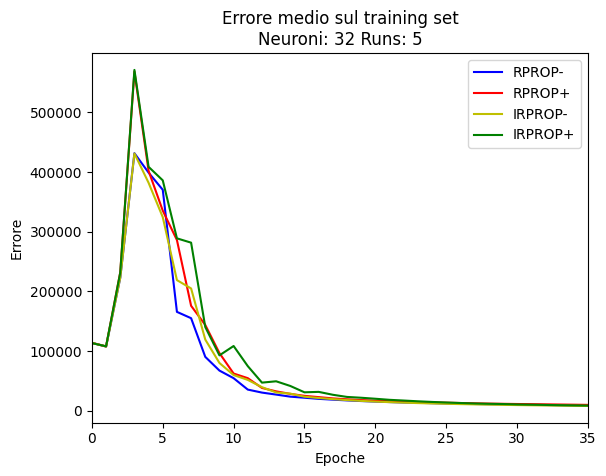

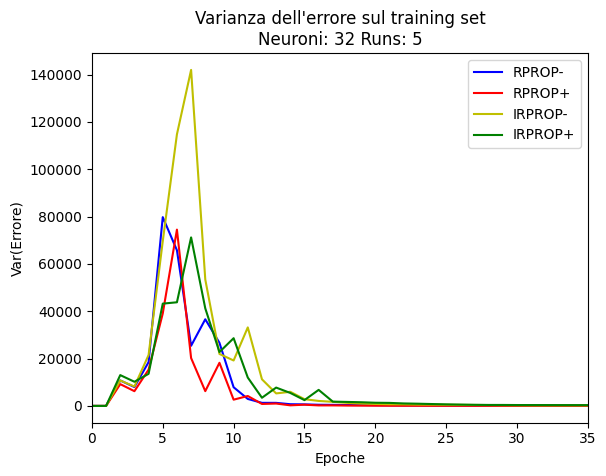

In [49]:
from matplotlib import pyplot as plt

# Stampo grafico dell'errore medio del train set
plt.figure()
plt.plot(std_metrics_mean[0], 'b', label='RPROP-')
plt.plot(plus_metrics_mean[0], 'r', label='RPROP+')
plt.plot(istd_metrics_mean[0], 'y', label='IRPROP-')
plt.plot(iplus_metrics_mean[0], 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Errore')
plt.title(f'Errore medio sul training set\nNeuroni: {', '.join(map(str, hidden_layers))} Runs: {number_of_runs}')
plt.legend()
plt.xlim(0, epochs)

# Salvo il plot come file PNG
plt.savefig(f'plots/{','.join(map(str, hidden_layers))}_train_err_mean_{number_of_runs}runs.png')

plt.show()
plt.close()


# Stampo grafico della varianza dell'errore del train set
plt.figure()
plt.plot(std_metrics_variance[0], 'b', label='RPROP-')
plt.plot(plus_metrics_variance[0], 'r', label='RPROP+')
plt.plot(istd_metrics_variance[0], 'y', label='IRPROP-')
plt.plot(iplus_metrics_variance[0], 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Var(Errore)')
plt.title(f'Varianza dell\'errore sul training set\nNeuroni: {', '.join(map(str, hidden_layers))} Runs: {number_of_runs}')
plt.legend()
plt.xlim(0, epochs)

# Salvo il plot come file PNG
plt.savefig(f'plots/{','.join(map(str, hidden_layers))}_train_err_var_{number_of_runs}runs.png')

plt.show()

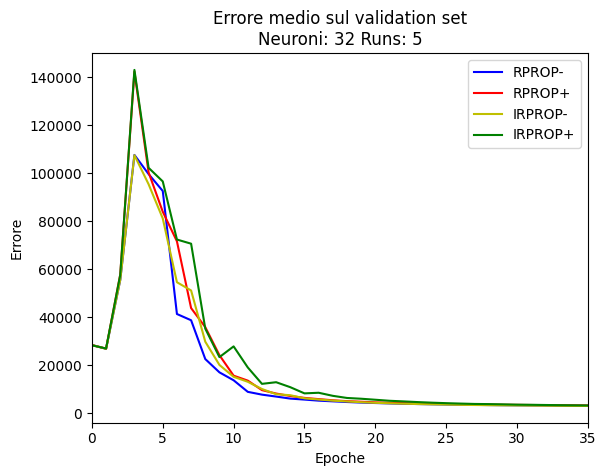

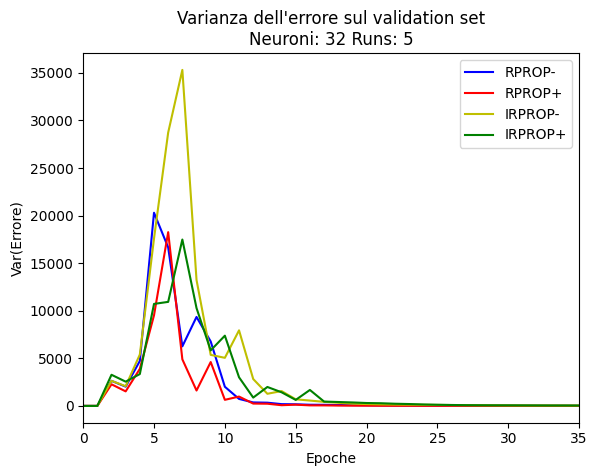

In [50]:
from matplotlib import pyplot as plt

# Stampa grafico dell'errore medio del validation set
plt.figure()
plt.plot(std_metrics_mean[1], 'b', label='RPROP-')
plt.plot(plus_metrics_mean[1], 'r', label='RPROP+')
plt.plot(istd_metrics_mean[1], 'y', label='IRPROP-')
plt.plot(iplus_metrics_mean[1], 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Errore')
plt.title(f'Errore medio sul validation set\nNeuroni: {', '.join(map(str, hidden_layers))} Runs: {number_of_runs}')
plt.legend()
plt.xlim(0, epochs)

# Salva il plot come file PNG
plt.savefig(f'plots/{','.join(map(str, hidden_layers))}_val_err_mean_{number_of_runs}runs.png')

plt.show()
plt.close()


# Stampa grafico della varianza dell'errore del validation set
plt.figure()
plt.plot(std_metrics_variance[1], 'b', label='RPROP-')
plt.plot(plus_metrics_variance[1], 'r', label='RPROP+')
plt.plot(istd_metrics_variance[1], 'y', label='IRPROP-')
plt.plot(iplus_metrics_variance[1], 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Var(Errore)')
plt.title(f'Varianza dell\'errore sul validation set\nNeuroni: {', '.join(map(str, hidden_layers))} Runs: {number_of_runs}')
plt.legend()
plt.xlim(0, epochs)

# Salva il plot come file PNG
plt.savefig(f'plots/{','.join(map(str, hidden_layers))}_val_err_var_{number_of_runs}runs.png')

plt.show()

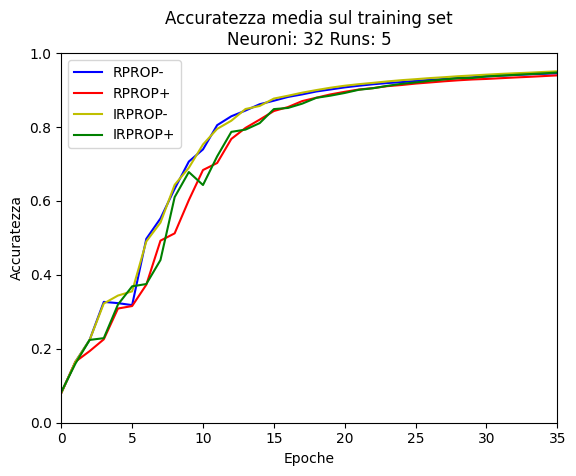

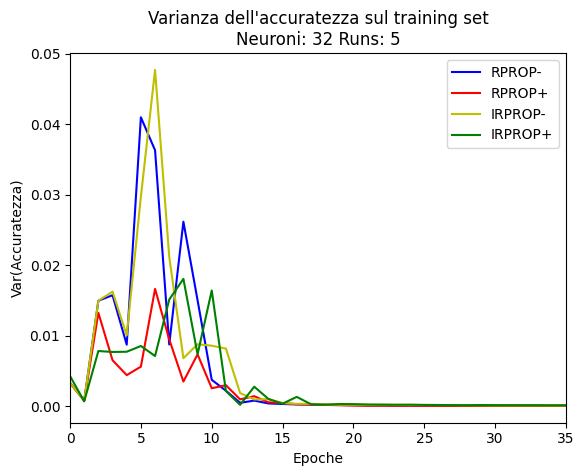

In [51]:
from matplotlib import pyplot as plt

# Stampa grafico dell'accuratezza media del train set
plt.figure()
plt.plot(std_metrics_mean[2], 'b', label='RPROP-')
plt.plot(plus_metrics_mean[2], 'r', label='RPROP+')
plt.plot(istd_metrics_mean[2], 'y', label='IRPROP-')
plt.plot(iplus_metrics_mean[2], 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Accuratezza')
plt.title(f'Accuratezza media sul training set\nNeuroni: {', '.join(map(str, hidden_layers))} Runs: {number_of_runs}')
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, epochs)

# Salva il plot come file PNG
plt.savefig(f'plots/{','.join(map(str, hidden_layers))}_train_acc_mean_{number_of_runs}runs.png')

plt.show()
plt.close()


# Stampa grafico della varianza dell'accuratezza del train set
plt.figure()
plt.plot(std_metrics_variance[2], 'b', label='RPROP-')
plt.plot(plus_metrics_variance[2], 'r', label='RPROP+')
plt.plot(istd_metrics_variance[2], 'y', label='IRPROP-')
plt.plot(iplus_metrics_variance[2], 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Var(Accuratezza)')
plt.title(f'Varianza dell\'accuratezza sul training set\nNeuroni: {', '.join(map(str, hidden_layers))} Runs: {number_of_runs}')
plt.legend()
plt.xlim(0, epochs)

# Salva il plot come file PNG
plt.savefig(f'plots/{','.join(map(str, hidden_layers))}_train_acc_var_{number_of_runs}runs.png')

plt.show()

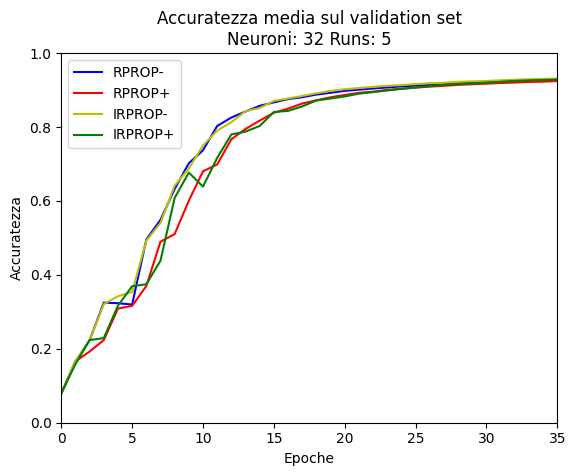

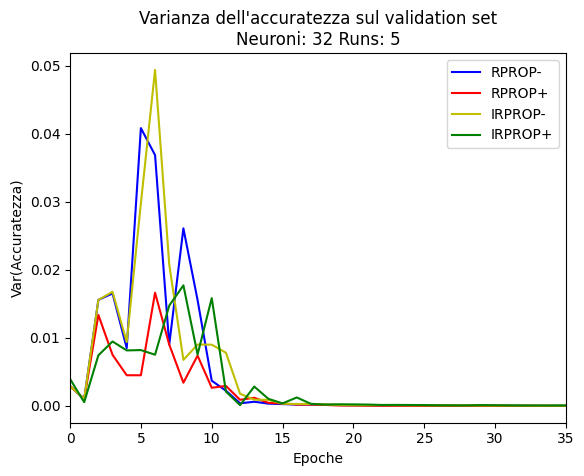

In [52]:
from matplotlib import pyplot as plt

# Stampa grafico dell'accuratezzaa media del validation set
plt.figure()
plt.plot(std_metrics_mean[3],  'b', label='RPROP-')
plt.plot(plus_metrics_mean[3], 'r', label='RPROP+')
plt.plot(istd_metrics_mean[3], 'y', label='IRPROP-')
plt.plot(iplus_metrics_mean[3], 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Accuratezza')
plt.title(f'Accuratezza media sul validation set\nNeuroni: {', '.join(map(str, hidden_layers))} Runs: {number_of_runs}')
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, epochs)

# Salva il plot come file PNG
plt.savefig(f'plots/{','.join(map(str, hidden_layers))}_val_acc_mean_{number_of_runs}runs.png')

plt.show()
plt.close()


# Stampa grafico della varianza dell'accuratezza del validation set
plt.figure()
plt.plot(std_metrics_variance[3],  'b', label='RPROP-')
plt.plot(plus_metrics_variance[3], 'r', label='RPROP+')
plt.plot(istd_metrics_variance[3], 'y', label='IRPROP-')
plt.plot(iplus_metrics_variance[3], 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Var(Accuratezza)')
plt.title(f'Varianza dell\'accuratezza sul validation set\nNeuroni: {', '.join(map(str, hidden_layers))} Runs: {number_of_runs}')
plt.legend()
plt.xlim(0, epochs)

# Salva il plot come file PNG
plt.savefig(f'plots/{','.join(map(str, hidden_layers))}_val_acc_var_{number_of_runs}runs.png')

plt.show()

In [53]:
# Scrive le stringhe nel CSV
with open("data/runs_mean_variance.csv", "a") as file:
     file.write(csv_string_std)
     file.write(csv_string_plus)
     file.write(csv_string_istd)
     file.write(csv_string_iplus)

Test Rprop-
Probabilità predette dalla rete:
Classe 0: 0.0
Classe 1: 0.0
Classe 2: 0.0
Classe 3: 0.0
Classe 4: 0.0
Classe 5: 0.0
Classe 6: 0.0
Classe 7: 0.0
Classe 8: 0.0
Classe 9: 1.0


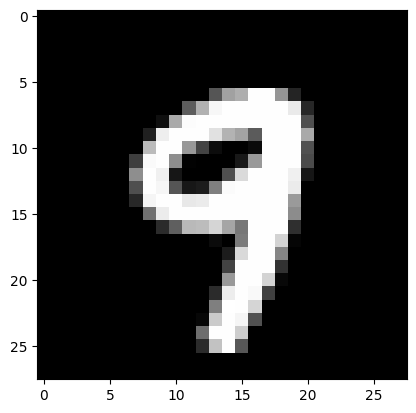

In [54]:
# Predizione rete addestrata con Rprop- (standard)
image = 8000

print('Test Rprop-')
std_training_net.test_prediction(image, test_X)

Test Rprop+
Probabilità predette dalla rete:
Classe 0: 0.0
Classe 1: 0.0
Classe 2: 0.0
Classe 3: 0.0
Classe 4: 0.0
Classe 5: 0.0
Classe 6: 0.0
Classe 7: 0.0
Classe 8: 0.0
Classe 9: 1.0


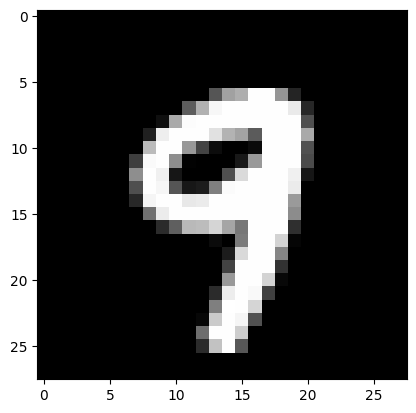

In [55]:
# Predizione rete addestrata con Rprop+ (Rprop con weight-backtracking)
image = 8000

print('Test Rprop+')
plus_training_net.test_prediction(image, test_X)

Test iRprop-
Probabilità predette dalla rete:
Classe 0: 0.0
Classe 1: 0.0
Classe 2: 0.0
Classe 3: 0.0
Classe 4: 0.0
Classe 5: 0.0
Classe 6: 0.0
Classe 7: 0.0
Classe 8: 0.0
Classe 9: 1.0


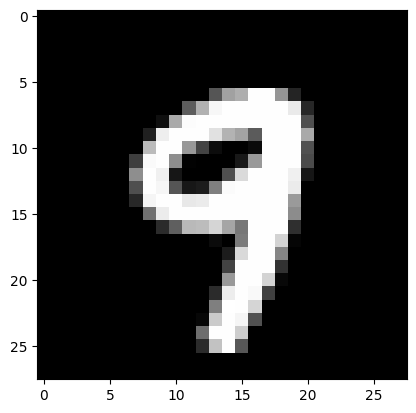

In [56]:
# Predizione rete addestrata con iRprop- (Improved Rprop)
image = 8000

print('Test iRprop-')
istd_training_net.test_prediction(image, test_X)

Test iRprop+
Probabilità predette dalla rete:
Classe 0: 0.0
Classe 1: 0.0
Classe 2: 0.0
Classe 3: 0.0
Classe 4: 0.0
Classe 5: 0.0
Classe 6: 0.0
Classe 7: 0.0
Classe 8: 0.0
Classe 9: 1.0


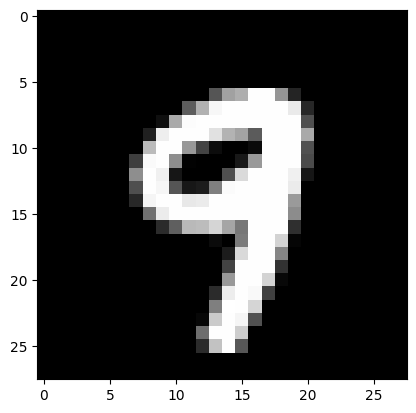

In [57]:
# Predizione rete addestrata con iRprop+ (Improved Rprop con weight-backtracking)
image = 8000

print('Test iRprop+')
iplus_training_net.test_prediction(image, test_X)